In [1]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    average_precision_score,
    make_scorer
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

from model import FraudDetector

# Notebook autoreload
%load_ext autoreload
%autoreload 2

# For reproducibility
RANDOM_STATE = 39

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv("historical.csv")
target = data["outcome"]

<div style="
    background: url('https://imgur.com/gtF7pEr.png') no-repeat center center; 
    background-size: cover;
    height: 1000px;
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    text-align: center;
    color: white;
    padding: 20px;
">
    <h1 style="font-size: 50px; font-weight: bold; margin: 10px;"></h1>
    <h2 style="font-size: 30px; font-style: italic; margin: 10px;"></h2>
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">ABSTRACT</h3>
</div>

<div style="font-family: 'Poppins', sans-serif; font-size: 15px; border-bottom: 2px solid #2a475e; padding-bottom: 15px">
<p style="line-height: 1.5; text-align: justify">
Figure 13  illustrates the top 20 Steam genres by frequency without outliers, offering insight into the dominant content categories within the platform. "Indie" leads as the most common genre, once again emphasizing the importance and volume of independently developed games on Steam. It is followed closely by "Casual," "Action," and "Adventure," all of which suggest a strong focus on approachable gameplay, fast-paced mechanics, and story-driven exploration. Mid-ranking genres such as "Simulation," "Strategy," and "RPG" also indicate a substantial share of games that cater to players seeking immersive and strategic experiences. Toward the bottom of the list, genres like "Utilities," "Education," and "Video Production" appear far less frequently, pointing to their niche status in the gaming ecosystem. Overall, this figure highlights the prevailing trends in genre popularity on Steam, where creative independence and accessible gameplay remain central to both developer output and player interest.
</p>
</div>

<div style="border-bottom: 1px solid #b6c6de; box-shadow: 0px 1px 0px #66c0f4; padding-bottom: 7px;">
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">INTRODUCTION</h3>
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">METHODOLOGY</h3>
</div>

<div style="text-align: center;">
    <img src="https://imgur.com/jygtZWn.png" alt="Cover" width="200">
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">EXPLORATORY DATA ANALYSIS</h3>
</div>

In [33]:
value_counts = data["outcome"].value_counts()
total = len(data)
'''
plt.figure(figsize=(8,6))

ax = sns.barplot(
    x=value_counts.index.map({0:"No Fraud", 1:"Fraud"}), 
    y=value_counts.values, 
    hue=value_counts.index.map({0:"No Fraud", 1:"Fraud"}),  # assign hue
    palette="pastel",
)
'''

# Add percentage labels on top of bars
for i, count in enumerate(value_counts.values):
    percent = 100 * count / total
    ax.text(
        i, count + 1000, f"{percent:.2f}%", 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )


#plt.title("Value Counts of Outcome")
#plt.ylabel("Count")
#plt.xlabel("Outcome")
#plt.show()

<div style="text-align: center;">
    <img src="https://imgur.com/jPCJSxy.png" alt="Boxplots of Numerical Features" width="700">
</div>

<div style="text-align: center;">
<p style="text-align: center; font-size: 14px; margin-bottom: 30px; margin-left: 100px; font-style: italic;">
    Figure 1. Count of fraudulent and non-fraudulent cases in data set
</p>
</div>

<div style="font-family: 'Poppins', sans-serif; font-size: 15px; padding-bottom: 25px">
<p style="line-height: 1.5; text-align: justify">
Figure 1 shows the count of the number of fraudulent and non-fraudulent cases within the data set. According to the bar graph only 0.2% of the data are fradulent cases. Therefore, telling us that there is a high class imbalance. An imbalance data set leads to misleading accuracies,  biased learning, and poor generalization. In other words, it makes it harder for models to identify the patterns of the minority class. Moving forward, the team will explore different methods of countering this imbalance.
</p>                                                                                                                                                           
</div>

<div style="padding-bottom: 7px;">
</div>

In [ ]:
corr_all = data.drop(columns=["tid"]).corr()

# Split by outcome
corr_outcome1 = data[data["outcome"] == 1].drop(columns=["tid"]).corr()
corr_outcome0 = data[data["outcome"] == 0].drop(columns=["tid"]).corr()

# Plot
#fig, axes = plt.subplots(1, 3, figsize=(24, 8))

#sns.heatmap(corr_all, annot=False, cmap="coolwarm", linewidths=0.5, ax=axes[0])
axes[0].set_title("Correlation Heatmap (All Data)", fontsize=14)

#sns.heatmap(corr_outcome1, annot=False, cmap="coolwarm", linewidths=0.5, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Outcome = 1)", fontsize=14)

#sns.heatmap(corr_outcome0, annot=False, cmap="coolwarm", linewidths=0.5, ax=axes[2])
axes[2].set_title("Correlation Heatmap (Outcome = 0)", fontsize=14)

#plt.tight_layout()
#plt.show()

<div style="text-align: center;">
    <img src="https://imgur.com/KvRIeQw.png" alt="Boxplots of Numerical Features" width="1600">
</div>

<div style="text-align: center;">
<p style="text-align: center; font-size: 14px; margin-bottom: 30px; margin-left: 20px; font-style: italic;">
    Figures 2-4. Correlation Heatmaps of PCA Components
</p>
</div>

<div style="font-family: 'Poppins', sans-serif; font-size: 15px; padding-bottom: 25px">
<p style="line-height: 1.5; text-align: justify">
The first correlation Map shows the correlation of all features with one another, while the others show the correlation of each features for fraudulent cases and non-fraudulent cases individually. Looking at the first correlation heatmap, the various PCAs seem to have little to no correlation to one another. However, when isolating the fraud data points, it reveals the multiple PCAs have strong correlations to one another. Therefore, indicating that the iambalance data makes it difficult to identify patterns within the minority class.
</p>                                                                                                                                                           
</div>

<div style="padding-bottom: 7px;">
</div>

In [ ]:
subset = data[[f"V{i}" for i in range(1, 4)] + ["outcome"]]

# Create pairplot
'''
sns.pairplot(
    data=subset,
    vars=[f"V{i}" for i in range(1, 4)],
    hue="outcome",
    palette="Set1",   # you can try "coolwarm", "husl", etc.
    diag_kind="kde",  # kde or hist for diagonal plots
    plot_kws={'alpha':0.6, 's':15}  # make points smaller/transparent for readability
)
'''
#plt.suptitle("Pairplot of V1–3 Colored by Outcome", y=1.02)
#plt.show()

<div style="text-align: center;">
    <img src="https://imgur.com/kH8HZxH.png" alt="Boxplots of Numerical Features" width="700">
</div>

<div style="text-align: center;">
<p style="text-align: center; font-size: 14px; margin-bottom: 30px; margin-left: 20px; font-style: italic;">
    Figure 5. Pairplot of PCA Components V1-3 by Outcome
</p>
</div>

<div style="font-family: 'Poppins', sans-serif; font-size: 15px; border-bottom: 2px solid #2a475e; padding-bottom: 15px">
<p style="line-height: 1.5; text-align: justify">
Figure 5 presents the relationship between the different principal components, while highlighting the fraudulent and non-fraudulent cases. Based on the pair plots, the fraud data points do not uniformly mix with the non-fraud data points. It forms it’s own clusters and bands, which means that the different principal components are able to identify significant patterns, showing distinct feature interactions. This is promising because it means the features do contain information to distinguish fraud, but the team needs to implement more than a simple linear model to capture it.
</p>
</div>

<div style="border-bottom: 1px solid #b6c6de; box-shadow: 0px 1px 0px #66c0f4; padding-bottom: 7px;">
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">RESULTS AND DISCUSSION</h3>
</div>

<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">Baseline: Untuned Random Forest</h5>
</div>

In [28]:
#needed for cores in macbook
import os, multiprocessing

# This gives logical cores
n_logical = multiprocessing.cpu_count()


n_logical = os.cpu_count()   # same as multiprocessing.cpu_count()
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_logical)
print(f"LOKY_MAX_CPU_COUNT set to {n_logical}")


LOKY_MAX_CPU_COUNT set to 12


In [32]:
def net_savings(y_true, y_pred, amounts):
    """
    Compute Net Savings = sum(TP amounts) - sum(FN amounts)
    
    Parameters:
    -----------
    y_true : array-like, true labels
    y_pred : array-like, predicted labels
    amounts : array-like, transaction amounts aligned with y_true
    
    Returns:
    --------
    float : net savings
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    amounts = np.array(amounts)
    
    # True Positives: fraud predicted as fraud
    tp_amount = amounts[(y_true == 1) & (y_pred == 1)].sum()
    
    # False Negatives: fraud predicted as non-fraud
    fn_amount = amounts[(y_true == 1) & (y_pred == 0)].sum()
    
    return tp_amount - fn_amount

def run_sampler_gridsearch(name, pipeline, param_grid, 
                           X_train, y_train, X_test, y_test, amt_test, 
                           results, cv=None, random_state=RANDOM_STATE):
    """
    Run GridSearchCV for a given sampler/classifier pipeline,
    optimize for Fraud Recall (FCR), evaluate on test set, 
    and append results.
    """

    # Define scorer for fraud recall
    fcr_scorer = make_scorer(recall_score, pos_label=1)
    
    if cv is None:
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        
    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=fcr_scorer,   # optimize for FCR
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Predictions on test set
    y_pred_test = best_model.predict(X_test)
    
    # Metrics
    precision = precision_score(y_test, y_pred_test)
    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test)
    fcr = recall_score(y_test, y_pred_test, pos_label=1) * 100
    net_sav = net_savings(y_test, y_pred_test, amt_test)
    
    # Append to results
    results.append({
        "Method": name,
        "Best Params": best_params,
        "Precision": precision,
        "Recall (Macro)": recall_macro,
        "F1": f1,
        "FCR (%)": fcr,
        "Net Savings": net_sav
    })
    
    return results

results = []

In [33]:
# Separate Amount and target
amounts = data['Amount']
y = data['outcome']

# Drop Amount + target from features
X = data.drop(columns=['Amount', 'outcome', 'tid'])

# Train/test split (20% hold-out)
X_train_full, X_test, y_train_full, y_test, amt_train_full, amt_test = train_test_split(
    X, y, amounts, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Train/validation split (20% val, 60% train)
X_train, X_val, y_train, y_val, amt_train, amt_val = train_test_split(
    X_train_full, y_train_full, amt_train_full,
    test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full
)

In [34]:
pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Empty param grid (nothing to tune)
param_grid_rf = {}

results = run_sampler_gridsearch(
    name="Random Forest (untuned)",
    pipeline=pipeline_rf,
    param_grid=param_grid_rf,   # empty grid
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    amt_test=amt_test,
    results=results,
    random_state=RANDOM_STATE
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=  25.4s
[CV] END .................................................... total time=  25.5s
[CV] END .................................................... total time=  26.6s


<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">SMOTE</h5>
</div>

In [19]:
# Smote Grid-Search
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        n_jobs=-1
    ))
])

param_grid_smote = {
    'smote__sampling_strategy': [0.2, 0.3],
    'smote__k_neighbors': [3, 5, 7, 9, 11],
}

# Define scorer based on fraud recall
fcr_scorer = make_scorer(recall_score, pos_label=1)

# Grid search
grid_search_smote = GridSearchCV(
    estimator=pipeline_smote,
    param_grid=param_grid_smote,
    scoring=fcr_scorer,   # optimize for FCR
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_search_smote.fit(X_train, y_train)

# Best estimator (max FCR)
best_model_smote = grid_search_smote.best_estimator_
best_params_smote = grid_search_smote.best_params_

# Predictions on test set
y_pred_test = best_model_smote.predict(X_test)

# Evaluate metrics
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test)
fcr = recall_score(y_test, y_pred_test, pos_label=1) * 100   # fraud recall %
net_sav = net_savings(y_test, y_pred_test, amt_test)         # use amt_test, not data['Amount']

# Append to results
results.append({
    "Method": "SMOTE",     # or "Undersampling", "Oversampling", etc.
    "Precision": precision,
    "Recall (Macro)": recall,
    "F1": f1,
    "FCR (%)": fcr,
    "Net Savings": net_sav
})

results

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.0min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.1min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.1min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.2min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.2min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 3.2min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 3.2min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 3.3min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 3.3min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.4min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 3.5min
[CV] END .smote__k_neighbors=3, smote__sampling_

[{'Method': 'SMOTE',
  'Precision': 0.8653846153846154,
  'Recall (Macro)': 0.8514678055923812,
  'F1': 0.7758620689655172,
  'FCR (%)': 70.3125,
  'Net Savings': np.float64(4842.460000000001)}]

In [37]:
# SMOTE
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=500, n_jobs=-1))
])

param_grid_smote = {
    'smote__sampling_strategy': [0.2, 0.3],
    'smote__k_neighbors': [3, 5, 7, 9, 11],
}

results = run_sampler_gridsearch("SMOTE", pipeline_smote, param_grid_smote,
                                 X_train, y_train, X_test, y_test, amt_test,
                                 results, random_state=RANDOM_STATE)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.2min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.2min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.2min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.3min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 3.4min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 3.5min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 3.5min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 3.5min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 3.6min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 3.7min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 3.7min
[CV] END .smote__k_neighbors=5, smote__sampling_

<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">SMOTE + Tomek</h5>
</div>

In [38]:
# SMOTE + Tomek
pipeline_smote_tomek = Pipeline([
    ('smote_tomek', SMOTE(random_state=RANDOM_STATE)),
    ('tomek', TomekLinks()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=500, n_jobs=-1))
])

param_grid_smote_tomek = {
    'smote_tomek__sampling_strategy': [0.2, 0.3],
    'smote_tomek__k_neighbors': [3, 5, 7, 9, 11],
}

results = run_sampler_gridsearch("SMOTE + Tomek", pipeline_smote_tomek, param_grid_smote_tomek,
                                 X_train, y_train, X_test, y_test, amt_test,
                                 results, random_state=RANDOM_STATE)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.2; total time= 3.5min
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.2; total time= 3.5min
[CV] END smote_tomek__k_neighbors=5, smote_tomek__sampling_strategy=0.2; total time= 3.6min
[CV] END smote_tomek__k_neighbors=5, smote_tomek__sampling_strategy=0.2; total time= 3.6min
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.2; total time= 3.6min
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.3; total time= 3.8min
[CV] END smote_tomek__k_neighbors=5, smote_tomek__sampling_strategy=0.2; total time= 3.8min
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.3; total time= 3.8min
[CV] END smote_tomek__k_neighbors=5, smote_tomek__sampling_strategy=0.3; total time= 3.8min
[CV] END smote_tomek__k_neighbors=3, smote_tomek__sampling_strategy=0.3; total time= 3.9min
[CV] END smote_tome

<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">ADASYN</h5>
</div>

In [40]:
# SMOTE
pipeline_adasyn = Pipeline([
    ('adasyn', ADASYN(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=500, n_jobs=-1))
])

param_grid_adasyn = {
    'adasyn__sampling_strategy': [0.2, 0.3],
    'adasyn__n_neighbors': [3, 5, 7, 9, 11],
}

results = run_sampler_gridsearch("ADASYN", pipeline_adasyn, param_grid_adasyn,
                                 X_train, y_train, X_test, y_test, amt_test,
                                 results, random_state=RANDOM_STATE)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.2; total time= 2.7min
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.2; total time= 2.8min
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.2; total time= 2.8min
[CV] END adasyn__n_neighbors=5, adasyn__sampling_strategy=0.2; total time= 2.9min
[CV] END adasyn__n_neighbors=5, adasyn__sampling_strategy=0.2; total time= 3.0min
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.3; total time= 3.0min
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.3; total time= 3.1min
[CV] END adasyn__n_neighbors=5, adasyn__sampling_strategy=0.2; total time= 3.1min
[CV] END adasyn__n_neighbors=3, adasyn__sampling_strategy=0.3; total time= 3.1min
[CV] END adasyn__n_neighbors=5, adasyn__sampling_strategy=0.3; total time= 3.2min
[CV] END adasyn__n_neighbors=5, adasyn__sampling_strategy=0.3; total time= 3.2min
[CV] END adasyn__n_neighbors=5, adasy

<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">ADASYN + Tomek</h5>
</div>

In [41]:

# ADASYN Grid-Search
pipeline_adasyn_tomek = Pipeline([
    ('adasyn_tomek', ADASYN(random_state=RANDOM_STATE)),
    ('tomek', TomekLinks()),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        n_jobs=-1
    ))
])

param_grid_adasyn_tomek = {
    'adasyn_tomek__sampling_strategy': [0.2, 0.3],
    'adasyn_tomek__n_neighbors': [3, 5, 7, 9, 11],
}

results = run_sampler_gridsearch("ADASYN + Tomek", pipeline_adasyn_tomek, param_grid_adasyn_tomek,
                                 X_train, y_train, X_test, y_test, amt_test,
                                 results, random_state=RANDOM_STATE)

results

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.2; total time= 3.0min
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.2; total time= 3.1min
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.2; total time= 3.2min
[CV] END adasyn_tomek__n_neighbors=5, adasyn_tomek__sampling_strategy=0.2; total time= 3.3min
[CV] END adasyn_tomek__n_neighbors=5, adasyn_tomek__sampling_strategy=0.2; total time= 3.3min
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.3; total time= 3.5min
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.3; total time= 3.5min
[CV] END adasyn_tomek__n_neighbors=5, adasyn_tomek__sampling_strategy=0.2; total time= 3.5min
[CV] END adasyn_tomek__n_neighbors=3, adasyn_tomek__sampling_strategy=0.3; total time= 3.6min
[CV] END adasyn_tomek__n_neighbors=5, adasyn_tomek__sampling_strategy=0.3; total time= 3.6min

[{'Method': 'Random Forest (untuned)',
  'Best Params': {},
  'Precision': 0.9361702127659575,
  'Recall (Macro)': 0.843709416682449,
  'F1': 0.7927927927927928,
  'FCR (%)': 68.75,
  'Net Savings': np.float64(-708.4899999999989)},
 {'Method': 'SMOTE',
  'Best Params': {'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.2},
  'Precision': 0.8064516129032258,
  'Recall (Macro)': 0.8904626667297963,
  'F1': 0.7936507936507936,
  'FCR (%)': 78.125,
  'Net Savings': np.float64(-423.9699999999998)},
 {'Method': 'SMOTE + Tomek',
  'Best Params': {'smote_tomek__k_neighbors': 7,
   'smote_tomek__sampling_strategy': 0.2},
  'Precision': 0.8064516129032258,
  'Recall (Macro)': 0.8904626667297963,
  'F1': 0.7936507936507936,
  'FCR (%)': 78.125,
  'Net Savings': np.float64(-423.9699999999998)},
 {'Method': 'ADASYN',
  'Best Params': {'adasyn__n_neighbors': 9, 'adasyn__sampling_strategy': 0.2},
  'Precision': 0.7936507936507936,
  'Recall (Macro)': 0.8904491389572793,
  'F1': 0.787401574803149

<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">Random Undersampling</h5>
</div>

In [42]:
pipeline_under = Pipeline([
    ('under', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        n_jobs=-1
    ))
])

param_grid_under = {}  # no tuning

results = run_sampler_gridsearch(
    "Random Undersampling",
    pipeline_under,
    param_grid_under,
    X_train, y_train, X_test, y_test, amt_test,
    results,
    random_state=RANDOM_STATE
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">Random Oversampling</h5>
</div>

In [43]:
pipeline_over = Pipeline([
    ('over', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        n_jobs=-1
    ))
])

param_grid_over = {}  # no tuning

results = run_sampler_gridsearch(
    "Random Oversampling",
    pipeline_over,
    param_grid_over,
    X_train, y_train, X_test, y_test, amt_test,
    results,
    random_state=RANDOM_STATE
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=  32.2s
[CV] END .................................................... total time=  32.2s
[CV] END .................................................... total time=  32.3s


<div style="padding: 0px; border-radius: 5px;">
    <h5 style="color: #215880; font-size: 20px; font-weight: bold; margin: 10px;">Class Weighting</h5>
</div>

In [44]:
# Define weights to test
weights = np.linspace(0, 100, 5)  # e.g. [0, 25, 50, 75, 100]

# Build pipeline
pipeline_cw = Pipeline([
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        n_jobs=-1
    ))
])

# Build param grid for class weights
param_grid_cw = {
    'clf__class_weight': [{0: w0, 1: 100 - w0} for w0 in weights]
}

# Run grid search with fraud recall optimization + store results
results = run_sampler_gridsearch(
    "Class Weights",
    pipeline_cw,
    param_grid_cw,
    X_train, y_train, X_test, y_test, amt_test,
    results,
    random_state=RANDOM_STATE
)

results


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END clf__class_weight={0: np.float64(0.0), 1: np.float64(100.0)}; total time=   3.3s
[CV] END clf__class_weight={0: np.float64(0.0), 1: np.float64(100.0)}; total time=   3.4s
[CV] END clf__class_weight={0: np.float64(0.0), 1: np.float64(100.0)}; total time=   3.6s
[CV] END clf__class_weight={0: np.float64(100.0), 1: np.float64(0.0)}; total time=   4.2s
[CV] END clf__class_weight={0: np.float64(100.0), 1: np.float64(0.0)}; total time=   4.2s
[CV] END clf__class_weight={0: np.float64(100.0), 1: np.float64(0.0)}; total time=   4.6s
[CV] END clf__class_weight={0: np.float64(25.0), 1: np.float64(75.0)}; total time= 2.0min
[CV] END clf__class_weight={0: np.float64(25.0), 1: np.float64(75.0)}; total time= 2.0min
[CV] END clf__class_weight={0: np.float64(25.0), 1: np.float64(75.0)}; total time= 2.0min
[CV] END clf__class_weight={0: np.float64(50.0), 1: np.float64(50.0)}; total time= 2.1min
[CV] END clf__class_weight={0: np.float6

[{'Method': 'Random Forest (untuned)',
  'Best Params': {},
  'Precision': 0.9361702127659575,
  'Recall (Macro)': 0.843709416682449,
  'F1': 0.7927927927927928,
  'FCR (%)': 68.75,
  'Net Savings': np.float64(-708.4899999999989)},
 {'Method': 'SMOTE',
  'Best Params': {'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.2},
  'Precision': 0.8064516129032258,
  'Recall (Macro)': 0.8904626667297963,
  'F1': 0.7936507936507936,
  'FCR (%)': 78.125,
  'Net Savings': np.float64(-423.9699999999998)},
 {'Method': 'SMOTE + Tomek',
  'Best Params': {'smote_tomek__k_neighbors': 7,
   'smote_tomek__sampling_strategy': 0.2},
  'Precision': 0.8064516129032258,
  'Recall (Macro)': 0.8904626667297963,
  'F1': 0.7936507936507936,
  'FCR (%)': 78.125,
  'Net Savings': np.float64(-423.9699999999998)},
 {'Method': 'ADASYN',
  'Best Params': {'adasyn__n_neighbors': 9, 'adasyn__sampling_strategy': 0.2},
  'Precision': 0.7936507936507936,
  'Recall (Macro)': 0.8904491389572793,
  'F1': 0.787401574803149

In [45]:
results_df = pd.DataFrame(results)
display(results_df)

,Method,Best Params,Precision,Recall (Macro),F1,FCR (%),Net Savings
0,Random Forest (untuned),{},0.936170,0.843709,0.792793,68.750,-708.49
1,SMOTE,"{'smote__k_neighbors': 7, 'smote__sampling_str...",0.806452,0.890463,0.793651,78.125,-423.97
2,SMOTE + Tomek,"{'smote_tomek__k_neighbors': 7, 'smote_tomek__...",0.806452,0.890463,0.793651,78.125,-423.97
3,ADASYN,"{'adasyn__n_neighbors': 9, 'adasyn__sampling_s...",0.793651,0.890449,0.787402,78.125,-423.97
4,ADASYN + Tomek,"{'adasyn_tomek__n_neighbors': 9, 'adasyn_tomek...",0.793651,0.890449,0.787402,78.125,-423.97
5,Random Undersampling,{},0.051756,0.923621,0.097731,87.500,4771.63
6,Random Oversampling,{},0.923077,0.874946,0.827586,75.000,-430.41
7,Class Weights,"{'clf__class_weight': {0: 0.0, 1: 100.0}}",0.001729,0.500000,0.003451,100.000,7177.73


In [ ]:
'''
net savings = (sum of amounts from TP) - (sum of amounts from FN)
'''

# Fixed fraud detection pipeline
This notebook loads `historical.csv`, creates a stratified train-test split, builds resampling pipelines (SMOTE, SMOTE+Tomek, ADASYN, ADASYN+Tomek) each with a RandomForest classifier, fits them, evaluates on the test set, and compares metrics (precision, recall, f1, and FCR = (FP+FN)/N).

In [28]:
# Prepare features and target
# Assumes the dataset has columns 'tid' and 'outcome' like in your original notebook.
# If your target column has a different name, update `target_col` below.
target_col = 'outcome'
id_col = 'tid' if 'tid' in data.columns else None

if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataframe. Available columns: {data.columns.tolist()}")

X = data.drop(columns=[target_col] + ([id_col] if id_col is not None else []))
y = data[target_col]

# If there's an 'Amount' column used in evaluation, ensure it's kept in a copy for later
amounts = X['Amount'].copy() if 'Amount' in X.columns else None

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Positive ratio (train):', y_train.mean(), 'Positive ratio (test):', y_test.mean())

Train shape: (148099, 29) Test shape: (37025, 29)
Positive ratio (train): 0.0017285734542434453 Positive ratio (test): 0.0017285617825793383


In [29]:
def make_rf():
    return RandomForestClassifier(
        n_estimators=500,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

pipelines = {
    "rf_only": Pipeline([
        ("rf", make_rf())
    ]),

    "undersampling": Pipeline([
        ("under", RandomUnderSampler(
            sampling_strategy=0.3,
            random_state=RANDOM_STATE
        )),
        ("rf", make_rf())
    ]),

    "oversampling": Pipeline([
        ("over", RandomOverSampler(
            sampling_strategy=1.0,
            random_state=RANDOM_STATE
        )),
        ("rf", make_rf())
    ]),

    "tomek": Pipeline([
        ("tomek", TomekLinks()),
        ("rf", make_rf())
    ]),

    "smote": Pipeline([
        ("smote", SMOTE(
            sampling_strategy=0.2,
            k_neighbors=7,
            random_state=RANDOM_STATE
        )),
        ("rf", make_rf())
    ]),

    "smote_tomek": Pipeline([
        ("smote", SMOTE(
            sampling_strategy=0.2,
            k_neighbors=7,
            random_state=RANDOM_STATE
        )),
        ("tomek", TomekLinks()),
        ("rf", make_rf())
    ]),

    "adasyn": Pipeline([
        ("adasyn", ADASYN(
            sampling_strategy=1.0,
            n_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("rf", make_rf())
    ]),

    "adasyn_tomek": Pipeline([
        ("adasyn", ADASYN(
            sampling_strategy=1.0,
            n_neighbors=5,
            random_state=RANDOM_STATE
        )),
        ("tomek", TomekLinks()),
        ("rf", make_rf())
    ]),

    "class_weight_balanced": Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),

    "class_weight_manual": Pipeline([
        ("rf", RandomForestClassifier(
            n_estimators=500,
            class_weight={0: 1, 1: 10},
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
}


In [30]:
# Fit all pipelines on training data
fitted_pipelines = {}
for name, pipe in pipelines.items():
    try:
        print('Fitting', name)
        pipe.fit(X_train, y_train)
        fitted_pipelines[name] = pipe
    except Exception as e:
        print('Error fitting', name, e)

len(fitted_pipelines), list(fitted_pipelines.keys())

Fitting rf_only
Fitting undersampling
Fitting oversampling
Fitting tomek
Fitting smote
Fitting smote_tomek
Fitting adasyn
Fitting adasyn_tomek
Fitting class_weight_balanced
Fitting class_weight_manual


(10,
 ['rf_only',
  'undersampling',
  'oversampling',
  'tomek',
  'smote',
  'smote_tomek',
  'adasyn',
  'adasyn_tomek',
  'class_weight_balanced',
  'class_weight_manual'])

In [34]:
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score
)

# -------------------------------
# Unified Fraud Evaluation
# -------------------------------
def evaluate_fraud_model(y_true, y_pred, y_proba, transaction_amounts, cost_fp=1, cost_fn_factor=1.0):
    """
    Evaluate fraud detection model performance with ML and business metrics.
    
    Parameters
    ----------
    y_true : array-like
        True labels (1 = fraud, 0 = normal).
    y_pred : array-like
        Predicted labels (1 = fraud, 0 = normal).
    y_proba : array-like
        Predicted probabilities for fraud class (for PR-AUC).
    transaction_amounts : array-like
        Dollar amount of each transaction.
    cost_fp : float
        Cost of investigating a false positive.
    cost_fn_factor : float
        Multiplier for fraud cost if missed (1.0 = full loss).
        
    Returns
    -------
    dict
        Metrics including precision, recall, f1, specificity, PR-AUC,
        fraud capture rate, net savings, and confusion matrix counts.
    """
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Classification metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Probability-based metric
    pr_auc = average_precision_score(y_true, y_proba)

    # Business metrics
    fraud_capture_rate = recall  # recall is capture rate
    savings_detected = transaction_amounts[(y_true == 1) & (y_pred == 1)].sum()
    losses_missed = transaction_amounts[(y_true == 1) & (y_pred == 0)].sum() * cost_fn_factor
    investigation_costs = fp * cost_fp
    net_savings = savings_detected - losses_missed - investigation_costs

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity,
        "pr_auc": pr_auc,
        "fraud_capture_rate": fraud_capture_rate * 100,
        "net_savings": net_savings,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

def compare_models(y_true, transaction_amounts, **model_outputs):
    """
    Compare multiple models using unified fraud metrics.
    
    model_outputs = { "model_name": (y_pred, y_proba), ... }
    """
    results = []
    for model_name, (y_pred, y_proba) in model_outputs.items():
        metrics = evaluate_fraud_model(y_true, y_pred, y_proba, transaction_amounts)
        metrics["model"] = model_name
        results.append(metrics)
    return pd.DataFrame(results).set_index("model").sort_values(by="fraud_capture_rate", ascending=False)


# -------------------------------
# Run evaluation on fitted pipelines
# -------------------------------
predictions = {}
for name, pipe in fitted_pipelines.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # probability of fraud
    predictions[name] = (y_pred, y_proba)

results_df = compare_models(
    y_true=y_test,
    transaction_amounts=X_test["Amount"],
    **predictions
).reset_index().rename(columns={"model": "Model"})


print(results_df)

                   Model  precision    recall        f1  specificity  \
0          undersampling   0.254717  0.843750  0.391304     0.995725   
1            smote_tomek   0.838710  0.812500  0.825397     0.999729   
2                  smote   0.838710  0.812500  0.825397     0.999729   
3           adasyn_tomek   0.836066  0.796875  0.816000     0.999729   
4                 adasyn   0.836066  0.796875  0.816000     0.999729   
5                rf_only   0.979167  0.734375  0.839286     0.999973   
6           oversampling   0.979167  0.734375  0.839286     0.999973   
7                  tomek   0.959184  0.734375  0.831858     0.999946   
8    class_weight_manual   0.979167  0.734375  0.839286     0.999973   
9  class_weight_balanced   0.978723  0.718750  0.828829     0.999973   

     pr_auc  fraud_capture_rate  net_savings     tn   fp  fn  tp  
0  0.638243             84.3750      3636.19  36803  158  10  54  
1  0.828243             81.2500       678.95  36951   10  12  52  
2  0.8

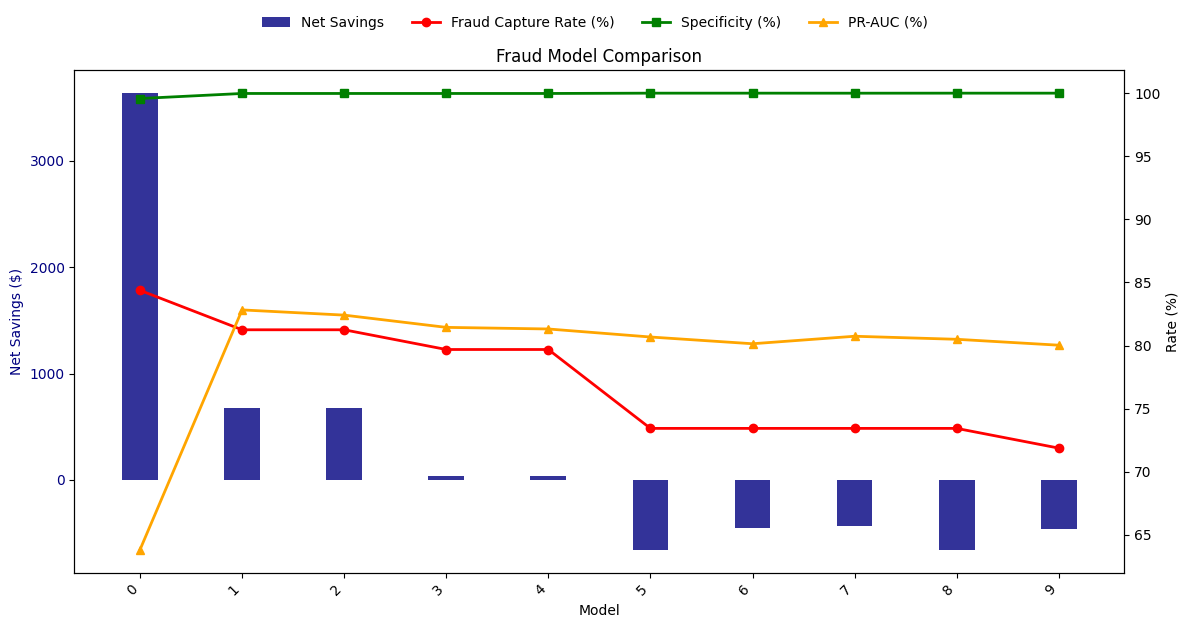

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(results_df))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(12,6))

# --- Bar chart for Net Savings ---
ax1.bar(x, results_df["net_savings"],
        width=bar_width, color="navy", alpha=0.8, label="Net Savings")

ax1.set_xlabel("Model")
ax1.set_ylabel("Net Savings ($)", color="navy")
ax1.tick_params(axis="y", labelcolor="navy")
ax1.set_xticks(x)
ax1.set_xticklabels(results_df.index, rotation=45, ha="right")

# --- Secondary axis ---
ax2 = ax1.twinx()
ax2.plot(x, results_df["fraud_capture_rate"],
         color="red", marker="o", linewidth=2, label="Fraud Capture Rate (%)")
ax2.plot(x, results_df["specificity"]*100,
         color="green", marker="s", linewidth=2, label="Specificity (%)")
ax2.plot(x, results_df["pr_auc"]*100,
         color="orange", marker="^", linewidth=2, label="PR-AUC (%)")

ax2.set_ylabel("Rate (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Legends
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05),
           ncol=4, frameon=False)

plt.title("Fraud Model Comparison")
plt.tight_layout()
plt.show()

In [ ]:
print("==========Untuned Random Forest==========")
print(f"Training F1 Score: {f1_score(y_train, rf_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_untuned_val)))

In [40]:
def merge_and_sum(dict1, dict2):
    merged = dict1.copy()
    for k, v in dict2.items():
        if k in merged:
            merged[k] += v
        else:
            merged[k] = v
    return merged

merge_and_sum({'a': 1, 'b': 2}, {'b': 3, 'c': 4})

KeyError: 'c'

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">CONCLUSION AND RECOMMENDATIONS</h3>
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">SUPPLEMENTARY MATERIALS</h3>
</div>

<div style="background-color: #215880; padding: 10px; border-radius: 5px;">
    <h3 style="color: #e6f1fa; font-size: 30px; font-weight: bold; margin: 10px;">REFERENCES</h3>
</div>